In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.neighbors import NearestNeighbors

## Create lorentz time series

In [2]:
# Parameters
T=4000 #sequence size
sigma=10
beta=8/3
rho=28
dt=0.01

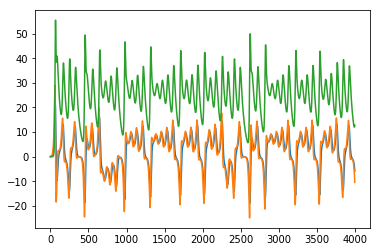

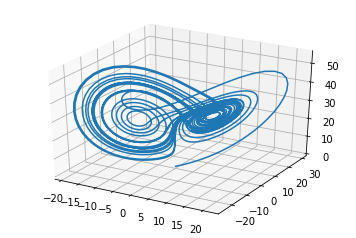

In [3]:
x=np.zeros((T+1))
y=np.zeros((T+1))
z=np.zeros((T+1))
x[0]=0.2*(np.random.rand()-0.5)
y[0]=0.2*(np.random.rand()-0.5)
z[0]=0.2*(np.random.rand()-0.5)

for i in range(T):
    x[i+1]=x[i]+dt*sigma*(y[i]-x[i])
    y[i+1]=y[i]+dt*(x[i]*(rho-z[i])-y[i])
    z[i+1]=z[i]+dt*(x[i]*y[i]-beta*z[i])

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(x)
ax.plot(y)
ax.plot(z)

fig2=plt.figure()
ax2=fig2.add_subplot(111,projection='3d')
ax2.plot(x,y,z)

### Create shadow manifold for X,Y and Z

In [75]:
E=3
tau=2
L=5 # number of samples from the time series sequence

In [76]:
def build_shadow_M (X,tau,E,T):
    '''Build the shadow manifold of the time series signal X, with E variables and sampling tau'''
    shadow_M=np.zeros((T-E+1,E))
    for i in range((tau*E-1),T):
        sample=np.zeros((E))
        for j in range(0,E):
            sample[j]=x[i-j*tau]
        shadow_M[i-(tau*E-1),:]=sample
    return shadow_M

In [77]:
shadow_x=build_shadow_M(x,tau,E,T)
shadow_y=build_shadow_M(y,tau,E,T)
shadow_z=build_shadow_M(z,tau,E,T)

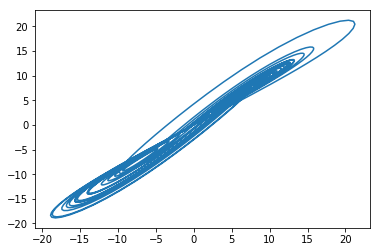

In [78]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot(shadow_x[:,0],shadow_x[:,1],shadow_x[:,2])

fig = plt.figure()
plt.plot(shadow_x[:,0],shadow_x[:,1])

### Sample the random manifold
Selec the value L, that reflects the number of points of the reconstructed manifold

In [229]:
L=200
def sample_manifold (M, L):
    '''Randomly select L points from the shadow manifold M'''
    new_M=np.zeros((L,M.shape[1]))
    idx=np.random.randint(M.shape[0], size=L)
    for i in range(L):
        new_M[i,:]=M[idx[i],:]
    return new_M, idx
            

In [230]:
recon_Mx, idx_x=sample_manifold(shadow_x,L)
recon_My, idx_y=sample_manifold(shadow_y,L)
recon_Mz, idx_z=sample_manifold(shadow_z,L)

### Find E+1 nearest neighbors

In [232]:
def nearest_points(M,idx,E):
    '''Find the E+2 nearest points to each point in the reconstructed manifold, it is only necessary E+1 
    but the first one is the point it self. The distance provided is the euclidean distance used to compute
    the weights in the weighted average for estimation.'''
    
    nbrs=NearestNeighbors(n_neighbors=E+2,algorithm='kd_tree',metric='euclidean').fit(M)
    distances, indices=nbrs.kneighbors(M)
    for i in range(len(indices)):
        for j in range(len(indices[i])):
            indices[i,j]=idx[indices[i,j]]
    return distances, indices

In [233]:
distances, indices=nearest_points(recon_Mx,idx_x,E)

### Compute predicted values

In [234]:
def compute_weights(distances,indices,eps=1*10^-8):
    weights=np.zeros((L,E+1))
    for i in range (L):
        weights[i,:]=np.exp(distances[i,1:E+2]/(eps+distances[i,1]))
        weights[i,:]=weights[i,:]/np.sum(weights[i,:])
    return weights

In [235]:
weights_w=compute_weights(distances,indices)

In [236]:
# check is sum is 1
boole=True 
for i in range(L):
    boole=boole&(sum(weights_w[i,:])-1.0<0.000001)
print (boole)

True


## Compute prediction Y(t)|Mx

In [238]:
def compute_prediction(Mx,shadow_y,weights,E,tau,L,indices):
    MY_pred=np.zeros((L,E))
    for i in range(L):
        for j in range(1,E+2):
            MY_pred[i,:]=MY_pred[i,:]+weights[i,j-1]*shadow_y[indices[i,j],:]
    MY_target=np.zeros((L,E))
    for l in range(L):
        MY_target[l,:]=shadow_y[indices[l,0],:]
    y_pred=MY_pred[:,0]
    y_target=MY_target[:,0]
    return MY_pred, MY_target, y_pred, y_target

In [239]:
My_pred,My_target,y_pred, y_target=compute_prediction(recon_Mx,shadow_y,weights_w,E,tau,L,indices)

### Compute correlation between predicted and target

In [242]:
def compute_corr(y_pred, y_target):
    corr=np.corrcoef(y_pred,y_target)[0,1]
    return corr

In [243]:
corr=compute_corr(y_pred,y_target)

## Convergent cross mapping

In [245]:
def compute_xmap(X,Y,T,E,tau,L,sample):
    '''Compute the convergent cross mapping between X and Y'''
    
    # Build the shadow manifold 
    shadow_x=build_shadow_M(X,tau,E,T)
    shadow_y=build_shadow_M(Y,tau,E,T)
    
    # Select randomly L points from the shadow manifold 
    recon_Mx, idx_x=sample_manifold(shadow_x,L)
    recon_My, idx_y=sample_manifold(shadow_y,L)  
    
    ########## Predict Y from X ##########################
    
    # find nearest neighbors
    distances_x, indices_x=nearest_points(recon_Mx,idx_x,E)
    
    # compute weights
    weights_w_x=compute_weights(distances_x,indices_x)
    
    # compute prediction
    My_pred,My_target,y_pred, y_target=compute_prediction(recon_Mx,shadow_y,weights_w_x,E,tau,L,indices)
    
    ########## Predict X from Y ##########################
    
    # find nearest neighbors
    distances_y, indices_y=nearest_points(recon_My,idx_y,E)
    
    # compute weights
    weights_w_y=compute_weights(distances_y,indices_y)
    
    # compute prediction 
    Mx_pred,Mx_target,x_pred, x_target=compute_prediction(recon_My,shadow_x,weights_w_y,E,tau,L,indices)
    
    return y_pred, y_target, x_pred, x_target